In [131]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


3.10.9 (main, Jan 11 2023, 09:18:20) [Clang 14.0.6 ]


In [132]:
# === import training dataset ========================================================================

# dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')
dataset_snow: pd.DataFrame = pd.read_pickle('/Users/redleader/PycharmProjects/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')

print(dataset_snow.head())

   init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0         0.0         0.0         0.0            0.0             0.0   
1         0.0         0.0         0.0            0.0             0.0   
2         0.0         0.0         0.0            0.0             0.0   
3         0.0         0.0         0.0            0.0             0.0   
4         0.0         0.0         0.0            0.0             0.0   

   init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0           0.0         0.0    0.000000     0.000000    6.337527  ...   
1           0.0         0.0    6.337527     6.558533    6.337527  ...   
2           0.0         0.0    6.337527     6.558533    6.337527  ...   
3           0.0         1.0   -5.933710     5.305197   -5.933710  ...   
4           0.0         1.0   -5.933710     5.305197   -5.933710  ...   

   body_vel_disturption_yaw_30  body_vel_disturption_yaw_31  \
0                     0.001605                     0.006716   
1 

In [133]:
# [*dataset_snow.keys()]

In [134]:
# === extract body_vel_distruptions arrays (output arrays) ===========================================

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

print(np.max(y_train_angular_slip))

2.8881285042196287


In [135]:
# === extract interpolated_icp =======================================================================

str_icp_interpolated_x_list = []
str_icp_interpolated_y_list = []
str_icp_interpolated_yaw_list = []
for i in range(0, 40):
    str_icp_interpolated_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_interpolated_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_interpolated_yaw_i = 'icp_interpolated_yaw_' + str(i)
    str_icp_interpolated_x_list.append(str_icp_interpolated_x_i)
    str_icp_interpolated_y_list.append(str_icp_interpolated_y_i)
    str_icp_interpolated_yaw_list.append(str_icp_interpolated_yaw_i)
    
icp_interpolated_x_array = dataset_snow[str_icp_interpolated_x_list].to_numpy()
icp_interpolated_y_array = dataset_snow[str_icp_interpolated_y_list].to_numpy()
icp_interpolated_yaw_array = dataset_snow[str_icp_interpolated_yaw_list].to_numpy()

In [136]:
# === extract icp vels ===============================================================================

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [137]:
# === extract idd_body_vel arrays (input arrays) =====================================================

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

# x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

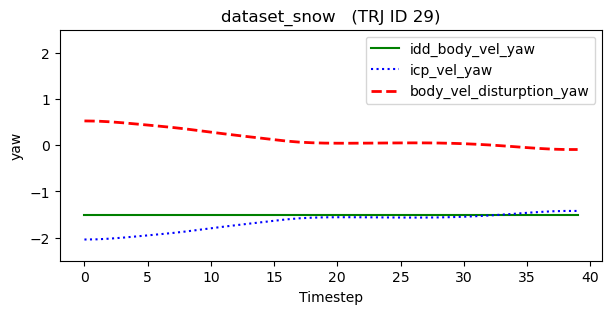

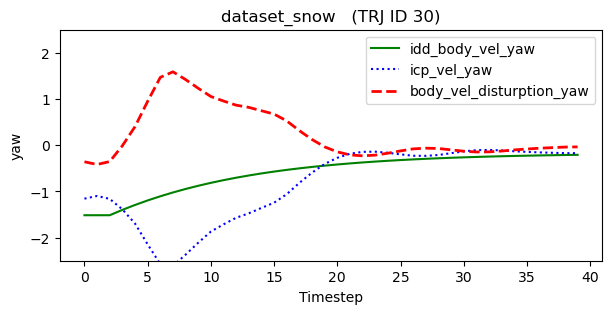

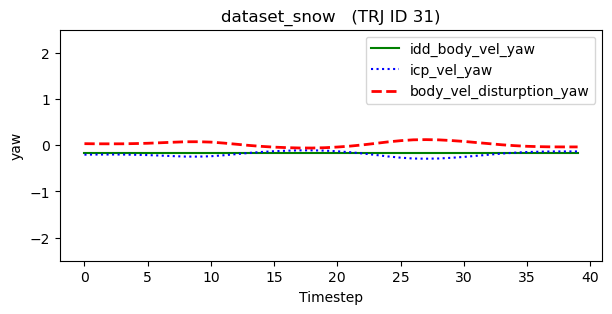

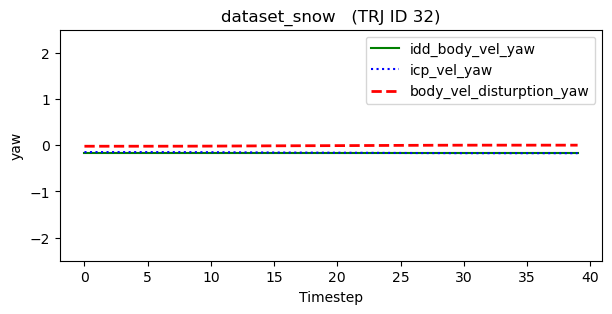

In [138]:
test_window = 32

def plot_dataset_trajectory(trajectory_id: int, title: str, y_label:str, ylim: tuple=(-2.5, 2.5)):
    fig = plt.figure(num=None, figsize=(7,3), dpi=None, facecolor=None, edgecolor=None)
    plt.title(f'{title}   (TRJ ID {trajectory_id})')
    plt.plot(idd_body_vel_yaw_array[trajectory_id, :], label="idd_body_vel_yaw", color="green")
    plt.plot(icp_vel_yaw_array[trajectory_id, :], label="icp_vel_yaw", color="blue", linestyle="dotted")
    # plt.plot(icp_interpolated_yaw_array[trajectory_nb, :], label="icp_interpolated_yaw", color="lightgray", linestyle="dotted")
    plt.plot(body_vel_disturption_yaw_array[trajectory_id, :], label="body_vel_disturption_yaw", color="red", linestyle="dashed", linewidth="2.")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Timestep')
    plt.ylim(*ylim)
    return None

# print(dataset_snow.loc[test_window]['icp_vel_x_1'])
# print(dataset_snow.loc[test_window]['icp_vel_x_2'])
# print(icp_interpolated_yaw_array[test_window])


_ids = [29,30,31,32]
# _ids = range(17,33)
for _trj_id in _ids:
    plot_dataset_trajectory(trajectory_id=_trj_id, title="dataset_snow", y_label="yaw", ylim=(-2.5, 2.5))


In [139]:
# === Split train/test dataset =======================================================================

# dataset_size = body_vel_disturption_yaw_array.shape[0]
dataset_size = int(body_vel_disturption_yaw_array.shape[0] *0.2)
trajectory_length = body_vel_disturption_yaw_array.shape[1]
DIMENSION = 1

def squeezer_for_dim1(_array:np.ndarray):
    if DIMENSION == 1:
        return _array.squeeze()
    else:
        return _array


X_train = np.linspace(start=np.zeros((DIMENSION,dataset_size)), stop=np.full((DIMENSION,dataset_size), trajectory_length), num=trajectory_length).transpose()
X_train[:,0,:] = idd_body_vel_x_array[0:dataset_size,:]
# X_train[:,1,:] = idd_body_vel_yaw_array

y_train = body_vel_disturption_yaw_array[0:dataset_size,:]
# _trasnposed = body_vel_disturption_yaw_array.transpose(1,0)

X_train = squeezer_for_dim1(X_train)
y_train = squeezer_for_dim1(y_train)

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=0)
X_train
X_test
y_train
y_test

array([[ 1.97782393e-02,  2.23189978e-02, -3.88779495e-03,
        -6.64028343e-02, -1.29130297e-01, -1.66323469e-01,
        -1.72811969e-01, -1.35117516e-01, -8.05042103e-02,
        -7.23474075e-02, -1.15482112e-01, -1.67774742e-01,
        -2.15201965e-01, -2.43613280e-01, -2.61649897e-01,
        -2.65261753e-01, -2.62662848e-01, -2.33248361e-01,
        -1.83293732e-01, -1.46113155e-01, -1.22744421e-01,
        -1.28243850e-01, -1.47138682e-01, -1.84288180e-01,
        -2.21558817e-01, -2.23117045e-01, -1.86969957e-01,
        -1.40676529e-01, -9.45102165e-02, -7.95749296e-02,
        -9.82245337e-02, -1.27154848e-01, -1.67980085e-01,
        -2.07631106e-01, -2.50160715e-01, -2.81628882e-01,
        -3.02555254e-01, -3.11856368e-01, -3.19723797e-01,
        -3.18488028e-01],
       [-1.97519238e-01, -1.83520645e-01, -1.13590447e-01,
        -1.16997020e-02,  3.42153533e-02,  2.19626620e-02,
         3.68948188e-03, -3.20632276e-02, -7.14969937e-02,
        -1.46858056e-01, -2.39

In [141]:
# === Create gaussian process ========================================================================
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# kernel = RBF()
kernel = 1.0 * RBF(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e09))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
# gpr.fit(x_train, y_train_angular_slip)
gpr.fit(X_train, y_train)

gpr.score(X_train, y_train)

# gpr.predict(X[:2,:], return_std=True)


0.7484318554742462

In [142]:
gpr.score(X_test, y_test)


-0.05268822947208111

In [143]:
# _trj_id_scater = slice(29,32)
#
# fig = plt.figure(num=None, figsize=(7,3), dpi=None, facecolor=None, edgecolor=None)
# x_train_squeeze = X_train[_trj_id_scater,:]
# y_train_sub = y_train[_trj_id_scater,:]
# plt.scatter(x_train_squeeze, y_train_sub, alpha=0.5)
# # ax.set_title('Example Scatter Plot')
# # ax.grid(True)
# # fig.tight_layout(pad=1)
#
# # plt.ylim(-2.5,2.5)
